In [1]:
import pandas as pd
import numpy as np

# Load your data
data = pd.read_csv('data/processed/merged.csv')  # Replace with your data file path

# Ensure all required columns are present
required_columns = ['location', 'bssid', 'dbm']
if not all(col in data.columns for col in required_columns):
    raise ValueError(f"Data must contain columns: {required_columns}")

# Handle missing values
data.dropna(subset=required_columns, inplace=True)

# Analyze class distribution
location_counts = data['location'].value_counts()
print("Number of samples per location:\n", location_counts)

Number of samples per location:
 location
GSR2-4          294
GSR2-3/2        240
SR2-3b          238
SR2-4b          233
GSR2-6          223
SR2-4a          220
GSR2-1          209
FToilet         206
CommonArea      189
SR2-3a          182
Walkway         172
PrintingRoom    166
Stair2          163
SR2-2a          161
Lift1           157
MToilet         156
Lift2           152
LW2.1b          146
Stairs3         143
Stairs1         130
Stairs2          59
SR2-2b           47
SR2-1b           39
SR2-1a           39
LW2.1a            1
Name: count, dtype: int64


In [2]:
# Map location names to coordinates
location_coords = {
            'FToilet': (26, 13),
            'GSR2-1': (25, 5),
            'GSR2-3/2': (16, 2),
            'GSR2-4': (16, 6),
            'PrintingRoom': (28, 9),
            'Stairs1': (31, 9),
            'Stair2': (11, 8),
            'LW2.1b': (30, 20),
            'Lift2': (23, 21),
            'Lift1': (20, 21),
            'MToilet': (18, 11),
            'Walkway': (15, 21),
            'CommonArea': (13, 35),
            'Stairs3': (12, 38),
            'SR2-4b': (9, 40),
            'SR2-4a': (9, 35),
            'SR2-3b': (11, 30),
            'GSR2-6': (11, 27),
            'SR2-3a': (11, 25),
            'SR2-2a': (11, 15),
            'SR2-2b': (11, 20),
            'SR2-1b': (11, 10),
            'SR2-1a': (10, 6),
            'Stairs2': (12, 8),
            'LW2.1a': (28, 9)
        }

# Add 'x' and 'y' columns based on location
data['x'] = data['location'].apply(lambda loc: location_coords.get(loc, (np.nan, np.nan))[0])
data['y'] = data['location'].apply(lambda loc: location_coords.get(loc, (np.nan, np.nan))[1])

# Remove entries with unknown coordinates
data.dropna(subset=['x', 'y'], inplace=True)

In [3]:
# Create a unique measurement ID for each set of measurements at a location
data['measurement_id'] = data.groupby(['location']).cumcount()

# Get a list of all unique BSSIDs
bssid_list = data['bssid'].unique()
bssid_to_idx = {bssid: idx for idx, bssid in enumerate(bssid_list)}

# Initialize lists for features and targets
features = []
targets = []

# Group data by measurement instances
grouped = data.groupby(['location', 'measurement_id'])

for (location, measurement_id), group in grouped:
    # Initialize RSSI vector with default value
    rssi_vector = np.full(len(bssid_list), -100.0)
    for _, row in group.iterrows():
        bssid = row['bssid']
        dbm = float(row['dbm'])
        idx = bssid_to_idx[bssid]
        rssi_vector[idx] = dbm  # Use the latest RSSI value
    features.append(rssi_vector)
    # Targets are the x and y coordinates
    x_coord = group['x'].iloc[0]
    y_coord = group['y'].iloc[0]
    targets.append([x_coord, y_coord])

# Convert to NumPy arrays
X = np.array(features)
y = np.array(targets)

In [4]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor

# Split the data into training and test sets (80% train, 20% test)
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [5]:
# Initialize the regression model
knn_regressor = KNeighborsRegressor(n_neighbors=3, metric='euclidean')

# Train the model
knn_regressor.fit(X_train, y_train)

KNeighborsRegressor(metric='euclidean', n_neighbors=3)

In [6]:
from sklearn.metrics import mean_absolute_error, mean_squared_error

# Predict on the test set
y_pred = knn_regressor.predict(X_test)

# Calculate evaluation metrics
mae = mean_absolute_error(y_test, y_pred)
rmse = np.sqrt(mean_squared_error(y_test, y_pred))

print(f"Mean Absolute Error: {mae:.2f} units")
print(f"Root Mean Squared Error: {rmse:.2f} units")

Mean Absolute Error: 6.69 units
Root Mean Squared Error: 9.04 units


In [7]:
def classify_location(x, y, location_coords):
    min_distance = float('inf')
    closest_location = 'Unknown Location'
    for location_name, (loc_x, loc_y) in location_coords.items():
        distance = np.sqrt((x - loc_x) ** 2 + (y - loc_y) ** 2)
        if distance < min_distance:
            min_distance = distance
            closest_location = location_name
    return closest_location

# Apply the classification to the test set predictions
estimated_locations = [classify_location(x, y, location_coords) for x, y in y_pred]
true_locations = [classify_location(x, y, location_coords) for x, y in y_test]

# Calculate classification accuracy
from sklearn.metrics import accuracy_score

classification_accuracy = accuracy_score(true_locations, estimated_locations)
print(f"Location Classification Accuracy: {classification_accuracy * 100:.2f}%")

Location Classification Accuracy: 7.94%


In [8]:
from sklearn.ensemble import RandomForestRegressor

# Initialize the model
rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

# Train the model
rf_regressor.fit(X_train, y_train)

# Predict and evaluate
y_pred_rf = rf_regressor.predict(X_test)
mae_rf = mean_absolute_error(y_test, y_pred_rf)
rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))
print(f"Random Forest MAE: {mae_rf:.2f} units")
print(f"Random Forest RMSE: {rmse_rf:.2f} units")

Random Forest MAE: 6.12 units
Random Forest RMSE: 8.40 units


In [9]:
# Map predicted coordinates to locations
estimated_locations_rf = [classify_location(x, y, location_coords) for x, y in y_pred_rf]

# Calculate classification accuracy
classification_accuracy_rf = accuracy_score(true_locations, estimated_locations_rf)
print(f"Random Forest Location Classification Accuracy: {classification_accuracy_rf * 100:.2f}%")

Random Forest Location Classification Accuracy: 8.58%


In [10]:
from sklearn.model_selection import cross_val_score

# Perform cross-validation with the regression model
cv_scores = cross_val_score(knn_regressor, X, y, cv=5, scoring='neg_mean_squared_error')
mean_rmse_cv = np.sqrt(-cv_scores.mean())
print(f"Cross-validated RMSE: {mean_rmse_cv:.2f} units")

Cross-validated RMSE: 9.24 units


In [11]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'n_neighbors': [1, 3, 5, 7],
    'metric': ['euclidean', 'manhattan'],
}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5, scoring='neg_mean_squared_error')
grid_search.fit(X_train, y_train)

best_knn = grid_search.best_estimator_
print(f"Best parameters: {grid_search.best_params_}")

Best parameters: {'metric': 'euclidean', 'n_neighbors': 3}


In [12]:
def calculate_distance(pred, true):
    return np.sqrt((pred[0] - true[0])**2 + (pred[1] - true[1])**2)

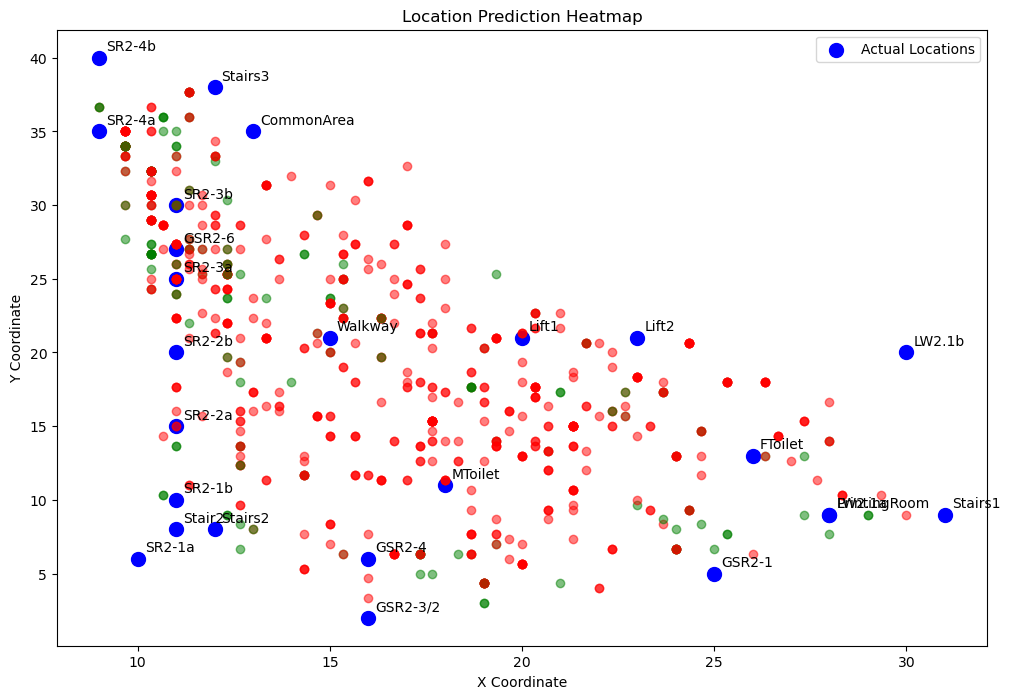

In [13]:
import matplotlib.pyplot as plt

def generate_heatmap(true_coords, pred_coords, location_coords, threshold=5):
    fig, ax = plt.subplots(figsize=(12, 8))

    # Plot actual locations
    for loc, (x, y) in location_coords.items():
        ax.scatter(x, y, c='blue', s=100, label='Actual Locations' if loc == list(location_coords.keys())[0] else "")
        ax.annotate(loc, (x, y), xytext=(5, 5), textcoords='offset points')

    # Plot predictions
    for true, pred in zip(true_coords, pred_coords):
        distance = calculate_distance(true, pred)
        color = 'green' if distance <= threshold else 'red'
        ax.scatter(pred[0], pred[1], c=color, alpha=0.5)

    ax.set_xlabel('X Coordinate')
    ax.set_ylabel('Y Coordinate')
    ax.set_title('Location Prediction Heatmap')
    ax.legend()
    plt.show()

# Usage
generate_heatmap(y_test, y_pred, location_coords)

In [21]:
threshold = 10

def calculate_accuracy(y_true, y_pred, threshold=5):
    distances = [calculate_distance(true, pred) for true, pred in zip(y_true, y_pred)]
    accurate_predictions = sum(1 for d in distances if d <= threshold)
    return accurate_predictions / len(y_true)

accuracy = calculate_accuracy(y_test, y_pred)
print(f"Accuracy (within {threshold} units): {accuracy:.2f}")

Accuracy (within 10 units): 0.21


In [16]:
average_error = np.mean([calculate_distance(true, pred) for true, pred in zip(y_test, y_pred)])
print(f"Average Error: {average_error:.2f} units")

Average Error: 10.79 units


In [22]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

knn_regressor.fit(X_train_scaled, y_train)
y_pred = knn_regressor.predict(X_test_scaled)

In [23]:
from sklearn.ensemble import RandomForestRegressor

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)
rf_regressor.fit(X_train_scaled, y_train)
y_pred_rf = rf_regressor.predict(X_test_scaled)

In [24]:
from sklearn.model_selection import GridSearchCV

param_grid = {'n_neighbors': [1, 3, 5, 7, 9, 11],
              'weights': ['uniform', 'distance'],
              'metric': ['euclidean', 'manhattan']}

grid_search = GridSearchCV(KNeighborsRegressor(), param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

best_knn = grid_search.best_estimator_
y_pred_best = best_knn.predict(X_test_scaled)

In [25]:
print(f"Best parameters: {grid_search.best_params_}")

from sklearn.metrics import mean_absolute_error, mean_squared_error

mae = mean_absolute_error(y_test, y_pred_best)

rmse = np.sqrt(mean_squared_error(y_test, y_pred_best))

print(f"Best KNN MAE: {mae:.2f} units")

print(f"Best KNN RMSE: {rmse:.2f} units")

rf_regressor = RandomForestRegressor(n_estimators=100, random_state=42)

rf_regressor.fit(X_train_scaled, y_train)

y_pred_rf = rf_regressor.predict(X_test_scaled)

mae_rf = mean_absolute_error(y_test, y_pred_rf)

rmse_rf = np.sqrt(mean_squared_error(y_test, y_pred_rf))

print(f"Random Forest MAE: {mae_rf:.2f} units")

print(f"Random Forest RMSE: {rmse_rf:.2f} units")

from sklearn.model_selection import cross_val_score

cv_scores = cross_val_score(best_knn, X, y, cv=5, scoring='neg_mean_squared_error')

mean_rmse_cv = np.sqrt(-cv_scores.mean())

print(f"Cross-validated RMSE: {mean_rmse_cv:.2f} units")


Best parameters: {'metric': 'manhattan', 'n_neighbors': 11, 'weights': 'distance'}
Best KNN MAE: 6.01 units
Best KNN RMSE: 8.16 units
Random Forest MAE: 6.14 units
Random Forest RMSE: 8.44 units
Cross-validated RMSE: 8.31 units
